# FIG CESM run evaluations

In [1]:
import os
import sys
import yaml
import argparse
from glob import glob
from datetime import datetime, timedelta

import numpy as np
import xarray as xr

sys.path.insert(0, os.path.realpath('../libs/'))
import graph_utils as gu
#import verif_utils as vu

In [2]:
import pandas as pd

In [3]:
import cmaps
# graph tools
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import matplotlib.colorbar as cbar
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import cartopy.crs as ccrs
import cartopy.mpl.geoaxes
import cartopy.feature as cfeature

%matplotlib inline

In [4]:
import matplotlib.lines as mlines

In [5]:
fig_keys = {
    'dpi': 150, 
    'orientation':'portrait', 
    'bbox_inches':'tight', 
    'pad_inches':0.1, 
    'transparent':False
}

In [6]:
need_publish = False

if need_publish:
    dpi_ = fig_keys['dpi']
else:
    dpi_ = 75

In [7]:
from numpy.lib.stride_tricks import sliding_window_view

def moving_average_axis(a, window, axis=-1, pad_mode="reflect"):
    a = np.asarray(a, dtype=float)
    if window < 1:
        raise ValueError("window must be >= 1")

    # asymmetric split works for even/odd windows
    pad_left  = (window - 1) // 2
    pad_right =  window // 2

    # Build pad widths for all axes; pad only along the chosen axis
    pad_widths = [(0, 0)] * a.ndim
    pad_widths[axis] = (pad_left, pad_right)

    apad = np.pad(a, pad_widths, mode=pad_mode)

    # Sliding windows along `axis`, then average over the last dim (window)
    sw = sliding_window_view(apad, window_shape=window, axis=axis)
    return sw.mean(axis=-1)

## Prep data

In [8]:
ind_spin = 16

In [9]:
ds_CESM = xr.open_zarr('/glade/campaign/ral/hap/ksha/GWC_results/CESM_scores/CESM_T2_tmean.zarr')
T2_smean_CESM = np.load('/glade/campaign/ral/hap/ksha/GWC_results/CESM_scores/CESM_T2_smean.npy')
T2_smean_CESM = T2_smean_CESM.mean(axis=0)

T2_tmean_CESM = ds_CESM['VAR_2T'].isel(time=slice(ind_spin, -1)).values
time_6hourly = ds_CESM['time'].isel(time=slice(ind_spin, -1)).values

T2_tmean_CESM_full = ds_CESM['VAR_2T'].values
time_6hourly_full = ds_CESM['time'].values

spread_CESM = T2_tmean_CESM.std(axis=0)
T2_tmean_CESM_ave = moving_average_axis(T2_tmean_CESM.mean(axis=0), window=30*4, axis=-1)

In [10]:
T2_smean_LAM = np.load('/glade/campaign/ral/hap/ksha/GWC_results/CESM_scores/LAM_T2_smean.npy')
T2_smean_LAM = T2_smean_LAM.mean(axis=0)

# hourly timeseries
ds_LAM = xr.open_zarr('/glade/campaign/ral/hap/ksha/GWC_results/CESM_scores/LAM_T2_tmean.zarr')
time_hourly = ds_LAM['time'].values
T2_tmean_LAM = ds_LAM['WRF_T2'].values
T2_tmean_LAM_ave = moving_average_axis(T2_tmean_LAM.mean(axis=0), window=30*4, axis=-1)

# 6 hourly for spread compute
ds_LAM_6h = ds_LAM.sel(time=ds_CESM['time'].isel(time=slice(ind_spin, -1)).values)
T2_tmean_LAM_6h = ds_LAM_6h['WRF_T2'].values
spread_LAM = T2_tmean_LAM_6h.std(axis=0)

In [11]:
fn = '/glade/campaign/ral/hap/ksha/GWC_results/CESM_scores/ZES_FFT_LAM_6H_CESM.npy'
ZES_LAM = np.load(fn, allow_pickle=True)[()]

fn = '/glade/campaign/ral/hap/ksha/GWC_results/CESM_scores/ZES_FFT_CESM_LENS.npy'
ZES_CESM = np.load(fn, allow_pickle=True)[()]

In [12]:
static_name = '/glade/derecho/scratch/ksha/DWC_data/CONUS_domain_GP/static/C404_GP_static.zarr'
ds_static = xr.open_zarr(static_name)
lon_WRF = ds_static['XLONG'].values
lat_WRF = ds_static['XLAT'].values

## Plot

In [13]:
scale_param = '50m'

PROVINCE = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale=scale_param,
    facecolor='none')

def map_gridline_opt(ax):
    '''
    Customize cartopy map gridlines
    '''
    # lat/lon gridlines and labeling
    # GL = ax.gridlines(crs=ccrs.PlateCarree(), 
    #                   draw_labels=False, x_inline=False, y_inline=False, 
    #                   color='k', linewidth=0.1, linestyle=':', zorder=5)
    # GL.top_labels = None; GL.bottom_labels = None
    # GL.right_labels = None; GL.left_labels = None
    # GL.xlabel_style = {'size': 14}; GL.ylabel_style = {'size': 14}
    # GL.rotate_labels = False
    ax.add_feature(cfeature.BORDERS.with_scale(scale_param), linestyle='-', linewidth=1.5, zorder=7)
    ax.add_feature(PROVINCE, edgecolor='k', linestyle='-', linewidth=1.5, zorder=7)
    ax.add_feature(cfeature.COASTLINE.with_scale(scale_param ), edgecolor='k', linewidth=1.5, zorder=5)
    ax.spines['geo'].set_linewidth(2.5)
    return ax

In [14]:
fig_dir = '/glade/u/home/ksha/CONUS-404-prep/figures/'

In [15]:
def dt_to_str(dt):
    return pd.to_datetime(dt).strftime('%y-%m-%dT%H')

In [16]:
LIM_t2 = [280, 300]
cmap_t2 = cmaps.t2m_29lev
skip_CESM_x = slice(None, None, 22) # ~ 0.9 deg
skip_CESM_y = slice(None, None, 30) # ~ 1.2 deg

In [17]:
COLORS = cmap_t2(np.linspace(0, 1, 29))

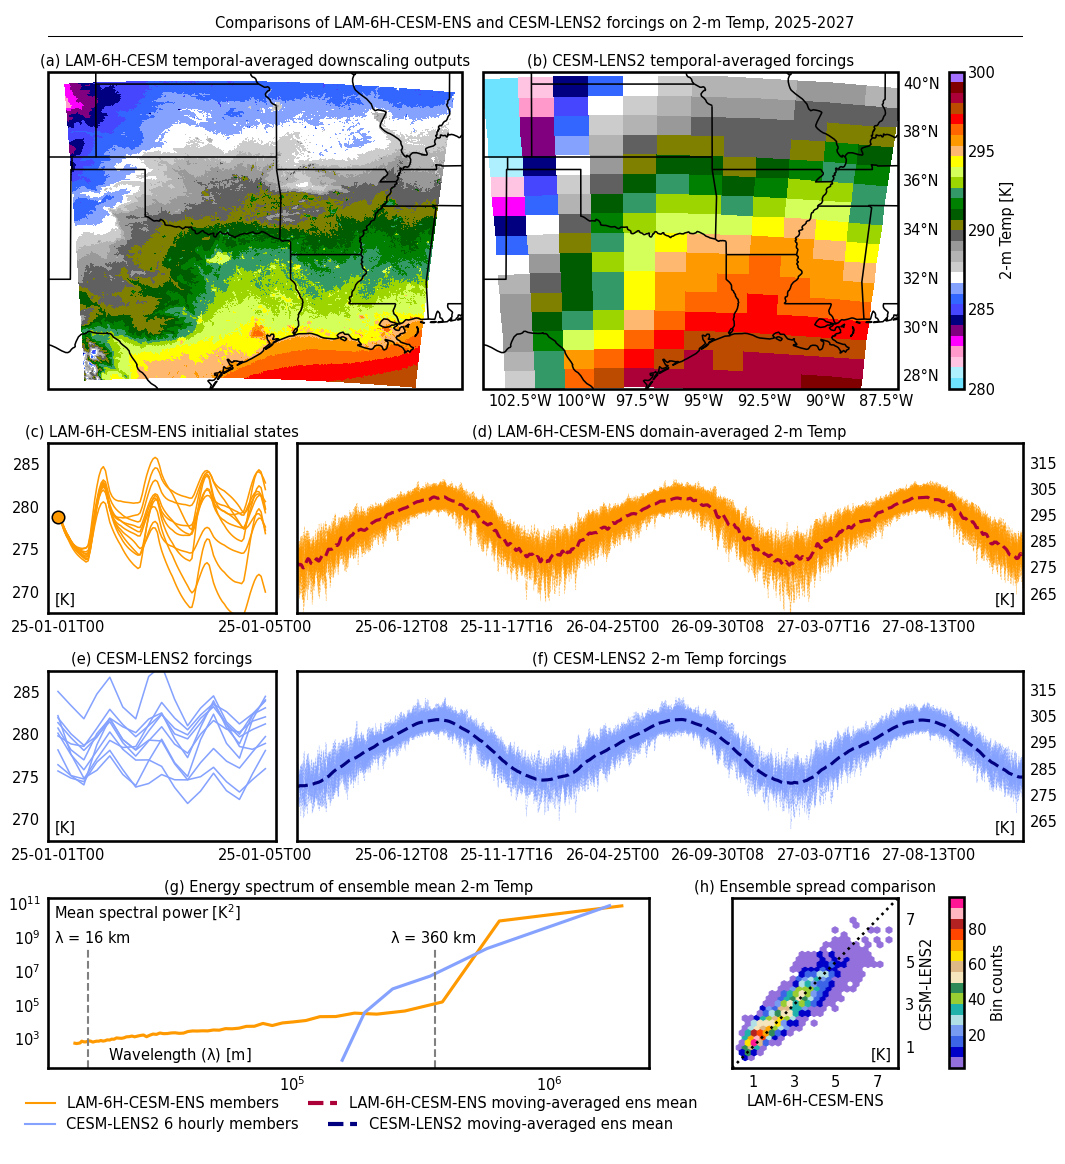

In [18]:
proj_ = ccrs.PlateCarree()
map_extent = [-104, -87, 27.5, 40.5]

fig = plt.figure(figsize=(13, 14), dpi=dpi_)
gs = gridspec.GridSpec(7, 16, height_ratios=[1, 0.0001, 0.4, 0.135, 0.4, 0.135, 0.4], width_ratios=[1,]*16)

AX_maps = []
AX_maps.append(plt.subplot(gs[0, 0:7], projection=proj_))
AX_maps.append(plt.subplot(gs[0, 7:14], projection=proj_))

AX_lines = []
AX_lines.append(plt.subplot(gs[2, 4:16]))
AX_lines.append(plt.subplot(gs[4, 4:16]))

AX_box = []
AX_box.append(plt.subplot(gs[2, 0:4]))
AX_box.append(plt.subplot(gs[4, 0:4]))
AX_box.append(plt.subplot(gs[6, 0:10]))
AX_box.append(plt.subplot(gs[6, 11:14]))

plt.subplots_adjust(0, 0, 1, 1, hspace=0.0, wspace=0.5)

for ax in AX_box + AX_lines:
    ax = gu.ax_decorate_box(ax)

for ax in AX_box:
    ax.tick_params(labelleft=True, labelbottom=True, labelsize=14)

AX_box[3].tick_params(labelleft=False, labelright=True, labelbottom=True, labelsize=14)

for ax in AX_lines:
    ax.set_xlim([0, 1])
    ax.set_ylim([257.5, 322.5])
    ax.set_yticks([265, 275, 285, 295, 305, 315])
    ax.tick_params(labelright=True, labelbottom=True, labelsize=14)

for ax in AX_maps:
    ax.set_extent(map_extent, crs=proj_)
    ax = map_gridline_opt(ax)

i_ax = 1
ax = AX_maps[i_ax]
    
GL = ax.gridlines(
    crs=ccrs.PlateCarree(), 
    draw_labels=True, x_inline=False, y_inline=False, 
    color=None, linewidth=0, zorder=5
)

GL.xlabel_style = {'size': 14}
GL.ylabel_style = {'size': 14}
GL.top_labels = None
GL.left_labels = None

# ============================================================================================= #

CS2 = AX_maps[0].pcolormesh(
    lon_WRF, lat_WRF, T2_smean_LAM,
    vmin=LIM_t2[0], vmax=LIM_t2[1], cmap=cmap_t2, transform=ccrs.PlateCarree()
)

AX_maps[1].pcolormesh(
    lon_WRF[skip_CESM_x, skip_CESM_y], 
    lat_WRF[skip_CESM_x, skip_CESM_y], 
    T2_smean_CESM[skip_CESM_x, skip_CESM_y],
    vmin=LIM_t2[0], vmax=LIM_t2[1], cmap=cmap_t2, transform=ccrs.PlateCarree()
)

AX_maps[0].set_title('(a) LAM-6H-CESM temporal-averaged downscaling outputs', fontsize=14)
AX_maps[1].set_title('(b) CESM-LENS2 temporal-averaged forcings', fontsize=14)

#0.925
ax_base2 = fig.add_axes([0.925, 0.647, 0.05, 0.302])
ax_base2.tick_params(
    axis='both', left=False, top=False, right=False, bottom=False, 
    labelleft=False, labeltop=False, labelright=False, labelbottom=False
)
cax2 = inset_axes(ax_base2, height='100%', width='30%', borderpad=0, loc=2)
CBar2 = plt.colorbar(CS2, orientation='vertical', cax=cax2)
CBar2.ax.tick_params(axis='y', labelsize=14, direction='in', length=0)
CBar2.outline.set_linewidth(2.5)
CBar2.set_ticks(np.arange(280, 300+5, 5))
CBar2.ax.set_ylabel('2-m Temp [K]', fontsize=14)

# ============================================================================================= #

fake_x1 = np.linspace(0, 1, len(T2_tmean_LAM_ave) - 6*ind_spin + 1)
fake_x2 = np.linspace(0, 1, len(T2_tmean_CESM_ave))

AX_lines[0].plot(fake_x1, T2_tmean_LAM[:, 6*ind_spin-1:].T, lw=0.5, ls=':', color=COLORS[22, :])
AX_lines[0].plot(fake_x1, T2_tmean_LAM_ave[6*ind_spin-1:], lw=3, ls='--', color=COLORS[26, :])
AX_lines[1].plot(fake_x2, T2_tmean_CESM.T, lw=0.5, ls=':', color=COLORS[9, :])
AX_lines[1].plot(fake_x2, T2_tmean_CESM_ave, lw=3, ls='--', color=COLORS[6, :])

AX_lines[0].set_xticks(fake_x1[::3800][1:]);
AX_lines[1].set_xticks(fake_x1[::3800][1:]);

text_ = []
time_hourly_label = time_hourly[6*ind_spin-1:][::3800]
for i in range(len(time_hourly_label)):
    text_.append(dt_to_str(time_hourly_label[i]))
    
AX_lines[0].set_xticklabels(text_[1:])
AX_lines[1].set_xticklabels(text_[1:])

for ax in AX_lines:
    ax.text(0.99, 0.03, '[K]', ha='right', va='bottom', fontsize=14, transform=ax.transAxes)


AX_lines[0].set_title('(d) LAM-6H-CESM-ENS domain-averaged 2-m Temp', fontsize=14)
AX_lines[1].set_title('(f) CESM-LENS2 2-m Temp forcings', fontsize=14)

# ============================================================================================= #

T2_tmean_LAM_init = np.vstack([np.full((1, 10), np.nan), T2_tmean_LAM[:, :96].T])
LAM_init_time = np.concatenate(([time_6hourly_full[0],], time_hourly[:96]), axis=0)

AX_box[0].set_title('(c) LAM-6H-CESM-ENS initialial states', fontsize=14)

for i in range(10):
    AX_box[0].plot(
        LAM_init_time, 
        T2_tmean_LAM_init[:, i], 
        color=COLORS[22, :]
    );

AX_box[0].plot(LAM_init_time[0], T2_tmean_LAM_init[1, 0], 'ro', ms=12, mew=1.5, mec='k', mfc=COLORS[22, :])

AX_box[0].set_xticks([LAM_init_time[0], LAM_init_time[-1]])
AX_box[0].set_xticklabels([dt_to_str(LAM_init_time[0]), dt_to_str(LAM_init_time[-1]),]);

AX_box[1].set_title('(e) CESM-LENS2 forcings', fontsize=14)

for i in range(10):
    AX_box[1].plot(
        time_6hourly_full[:17], 
        T2_tmean_CESM_full[i, :17], 
        color=COLORS[9, :]
    );
AX_box[1].set_xticks([time_6hourly_full[0], time_6hourly_full[16]])
AX_box[1].set_xticklabels([dt_to_str(time_6hourly_full[0]), dt_to_str(time_6hourly_full[16]),]);

for ax in AX_box[:2]:
    ax.set_ylim([267.5, 287.5])
    ax.text(0.03, 0.03, '[K]', ha='left', va='bottom', fontsize=14, transform=ax.transAxes)
    
# ============================================================================================= #

# # linear interp to match wavelength axis
# y_new = np.interp(ZES_LAM['wavelength'][:], ZES_CESM['wavelength'][:], ZES_CESM['ZES'][:])
# y_new[:161] = np.nan # small wavelength is extrapolation, mark as NaNs 

AX_box[2].plot(ZES_LAM['wavelength'][100:]*1e3, ZES_LAM['ZES'][100:], lw=3, ls='-', color=COLORS[22, :])
AX_box[2].plot(ZES_CESM['wavelength'][:]*1e3, ZES_CESM['ZES'][:], lw=3, ls='-', color=COLORS[9, :])
AX_box[2].set_xscale('log')
AX_box[2].set_yscale('log')
AX_box[2].set_title('(g) Energy spectrum of ensemble mean 2-m Temp', fontsize=14)
AX_box[2].text(
    0.1, 0.015, 'Wavelength ($\mathsf{\lambda}$) [m]', 
    ha='left', va='bottom', fontsize=14, transform=AX_box[2].transAxes)
AX_box[2].text(
    0.01, 0.975, 'Mean spectral power [K$\mathsf{^2}$]', 
    ha='left', va='top', fontsize=14, transform=AX_box[2].transAxes)

AX_box[2].axvline(
    x=16000, color='0.5', linestyle='--', linewidth=2, ymin=0.0, ymax=0.7)
AX_box[2].axvline(
    x=360000, color='0.5', linestyle='--', linewidth=2, ymin=0.0, ymax=0.7)

AX_box[2].text(
    0.01, 0.72, '$\mathsf{\lambda}$ = 16 km', 
    ha='left', va='bottom', fontsize=14, transform=AX_box[2].transAxes)

AX_box[2].text(
    0.57, 0.72, '$\mathsf{\lambda}$ = 360 km', 
    ha='left', va='bottom', fontsize=14, transform=AX_box[2].transAxes)

# AX_box[2].set_xlim([1.2e4, 4e5])

# ============================================================================================= #

CS_hex = AX_box[3].hexbin(
    spread_LAM, spread_CESM, 
    gridsize=25,
    cmap=cmaps.amwg,#cmap_t2,
    mincnt=1,
    bins=None
)
fake_x = np.linspace(0, 8, 50)
AX_box[3].plot(fake_x, fake_x, ':', lw=2.5, color='k')

AX_box[3].set_ylabel('CESM-LENS2', fontsize=14)
AX_box[3].yaxis.set_label_position("right")
AX_box[3].set_xlabel('LAM-6H-CESM-ENS', fontsize=14)
AX_box[3].set_title('(h) Ensemble spread comparison', fontsize=14) #x=0.75, 
AX_box[3].set_xlim([0, 8]);
AX_box[3].set_xticks([1, 3, 5, 7]);
AX_box[3].set_ylim([0, 8]);
AX_box[3].set_yticks([1, 3, 5, 7]);
AX_box[3].text(0.96, 0.03, '[K]', ha='right', va='bottom', fontsize=14, transform=AX_box[3].transAxes)

ax_base3 = fig.add_axes([0.925, 0.0, 0.05, 0.1625])
ax_base3.tick_params(
    axis='both', left=False, top=False, right=False, bottom=False, 
    labelleft=False, labeltop=False, labelright=False, labelbottom=False
)
cax3 = inset_axes(ax_base3, height='100%', width='30%', borderpad=0, loc=2)
CBar3 = plt.colorbar(CS_hex, orientation='vertical', cax=cax3)
CBar3.ax.tick_params(axis='y', labelsize=14, direction='in', length=0)
CBar3.outline.set_linewidth(2.5)
CBar3.ax.set_ylabel('Bin counts', fontsize=14)#, labelpad=-47.5)

handle_legneds1 = []
handle_legneds1.append(mlines.Line2D([], [], lw=2, ls='-', color=COLORS[22, :]))
handle_legneds1.append(mlines.Line2D([], [], lw=4, ls='--', color=COLORS[26, :]))

handle_legneds2 = []
handle_legneds2.append(mlines.Line2D([], [], lw=2, ls='-', color=COLORS[9, :]))
handle_legneds2.append(mlines.Line2D([], [], lw=4, ls='--', color=COLORS[6, :]))

ax_lg2 = fig.add_axes([-0.035, -0.0843, 0.69, 0.05])
LG2 = ax_lg2.legend(
    handle_legneds2, 
    ['CESM-LENS2 6 hourly members', 'CESM-LENS2 moving-averaged ens mean'], 
    bbox_to_anchor=(1, 1), ncol=2, prop={'size':14}
)

ax_lg1 = fig.add_axes([-0.035, -0.0643, 0.715, 0.05])
LG1 = ax_lg1.legend(
    handle_legneds1, 
    ['LAM-6H-CESM-ENS members', 'LAM-6H-CESM-ENS moving-averaged ens mean'], 
    bbox_to_anchor=(1, 1), ncol=2, prop={'size':14}
)

ax_title1 = fig.add_axes([0.0, 0.98, 1.0, 0.03])

ax_title1.text(
    0.5, 0.5, 
    'Comparisons of LAM-6H-CESM-ENS and CESM-LENS2 forcings on 2-m Temp, 2025-2027', 
    fontsize=14, va='center', ha='center', transform=ax_title1.transAxes
)

ax_title1.axhline(y=0.1, lw=1, ls='-', color='k')

ax_title1.set_axis_off()
ax_base2.set_axis_off()
ax_base3.set_axis_off()
LG1 = gu.lg_box(LG1)
LG2 = gu.lg_box(LG2)
ax_lg1.set_axis_off()
ax_lg2.set_axis_off()